<a href="https://colab.research.google.com/github/supertime1/Afib_PPG/blob/master/Afib_PPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Introduction

This notebook processes the ECG and PPG signals.（https://archive.physionet.org/physiobank/database/mimic3wdb/matched/ ）

The Deep-ECG model is used to label the ECG, as well as PPG signals. The output is PPG signals with 30s segements at 300 Hz, with Afib and NSR labels. The output data will be used to train a Deep-PPG model in Afib_PPG notebook.

#2.Setup Environment

In [0]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext tensorboard
import numpy as np
import os
import shutil
import glob
import wfdb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model 
from tensorflow.keras.callbacks import TensorBoard
import tensorflow_datasets as tfds
import multiprocessing
from datetime import datetime
import sklearn.metrics
import itertools
import io
import pickle
print(tf.__version__)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
2.1.0


In [0]:
#run this cell if multiple GPUs are used
tf.debugging.set_log_device_placement(True)

In [0]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

In [0]:
tf.test.is_built_with_cuda()

True

#3.Load ECG and PPG data

In [0]:
hd_names = []
for name in glob.glob("D:/WFDB/matched/p00/*/[0-9]*[!layout][!n].dat"):
  if os.path.getsize(name) < 17*1024:
    continue
  position = name.index('.')
  name = name[0:position] #remove the .hea part to comply the wfdb.rdrecord format
  hd_names.append(name)
print("There are total ", len(hd_names), "records that are bigger than 17kb")

There are total  27303 records that are bigger than 17kb


In [0]:
qualified_names = [] #a list of file names that contain both PPG and ECG Lead I waveforms
for name in hd_names:
  record = wfdb.rdheader(name)
  if 'I' in record.sig_name and 'PLETH' in record.sig_name and record.sig_len >= 75000: #extact only records contrains ECG lead I and PPG, and >=10min
    qualified_names.append(name)
print('There are total', len(qualified_names), 'records that have both ECG and PPG with more than 10min recording')

There are total 361 records that have both ECG and PPG with more than 10min recording


In [0]:
##use the same name for wfdb.rdrecord
##sampling freq is 125 Hz for both ECG and PPG: 
##Documentation: https://archive.physionet.org/physiobank/database/mimic3wdb/
ECG_signals = [] #create a  list to store all  ECG signals
PPG_signals = [] #create a  list to store all  PPG signals
for name in qualified_names:
  record = wfdb.rdrecord(name)

  ECG_index = record.sig_name.index('I')
  PPG_index = record.sig_name.index('PLETH')
  ECG_sig = record.p_signal.T[ECG_index]
  PPG_sig = record.p_signal.T[PPG_index]

  if np.isnan(ECG_sig).any() or np.isnan(PPG_sig).any(): ##remove list with all empty signals
    continue
  else:
    ECG_signals.append(ECG_sig)
    PPG_signals.append(PPG_sig)

print('ECG signals len:', len(ECG_signals))
print('PPG signals len:', len(PPG_signals))

ECG signals len: 214
PPG signals len: 214


In [0]:
#save the data
#save ECG data
with open('D:/WFDB/matched/ECG_signals.pkl', "wb") as fp:
  pickle.dump(ECG_signals, fp)
#save PPG data
with open('D:/WFDB/matched/PPG_signals.pkl', "wb") as fp:
  pickle.dump(PPG_signals, fp)

In [0]:
with open('D:/WFDB/matched/ECG_signals.pkl', "rb") as fp:
  raw_ECG_signals = pickle.load(fp)

#4.Process ECG data

## 4.1 Resample ECG signals 

In [0]:
#use wfdb.resample
from wfdb import processing
resamp_ECG_signals = []
for i in range(len(ECG_signals)):
  resamp_ECG_signal, _ = wfdb.processing.resample_sig(raw_ECG_signals[i],125,300)
  resamp_ECG_signals.append(new_ECG_signal)
#apply filters before using DEEP-ECG to label it

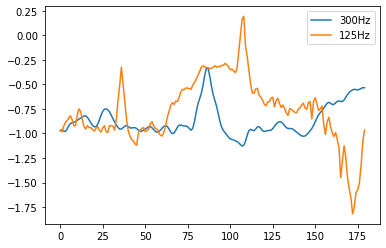

In [0]:
plt.plot(resamp_ECG_signals[1][:180]*-1,label = "300Hz")
plt.plot(raw_ECG_signals[1][:180]*-1, label="125Hz")
plt.legend()

In [0]:
with open('D:/WFDB/matched/ECG_signals_300HZ.pkl', "wb") as fp:
  pickle.dump(resamp_ECG_signals, fp)

In [0]:
with open('D:/WFDB/matched/ECG_signals_300HZ.pkl', "rb") as fp:
  resamp_ECG_signals = pickle.load(fp)

##4.2 Flip ECG signals

In [0]:
rev_ECG_signals = np.multiply(resamp_ECG_signals, -1)

In [0]:
print("After band pass filtering, there are:", len(rev_ECG_signals), "records")

After band pass filtering, there are: 214 records


In [0]:
plt.plot(resamp_ECG_signals[1][:180]*-1,label = "not flipped")
plt.plot(rev_ECG_signals[1][:180]*-1, label="flipped")
plt.legend()

##4.3 Band pass filter



In [0]:
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [0]:
bf_ECG_signals = []
for i in range(len(rev_ECG_signals)):
  bf_ECG_signal =butter_bandpass_filter(rev_ECG_signals[i],0.2,8,300,order=3)
  bf_ECG_signals.append(f_ECG_signal)
print("After band pass filtering, there are:", len(bf_ECG_signals), "records")

214


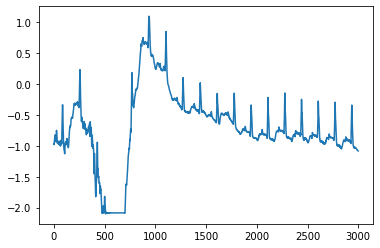

In [0]:
plt.plot(rev_ECG_signals[1][:3000],label="before band pass filtering")
plt.plot(bf_ECG_signals[1][:3000], label="after band pass filtering")
plt.legend()

##4.4 Normalization

##4.5 Hampel filter

In [0]:
def hampel_filter_forloop(input_series, window_size, n_sigmas=3):
    
    n = len(input_series)
    new_series = input_series.copy()
    k = 1.4826 # scale factor for Gaussian distribution
    
    indices = []
    
    # possibly use np.nanmedian 
    for i in range((window_size),(n - window_size)):
        x0 = np.median(input_series[(i - window_size):(i + window_size)])
        S0 = k * np.median(np.abs(input_series[(i - window_size):(i + window_size)] - x0))
        if (np.abs(input_series[i] - x0) > n_sigmas * S0):
            new_series[i] = x0
            indices.append(i)
    
    return new_series, indices

In [0]:
hf_ECG_signals=[]
for i in range(len(bf_ECG_signals)):
  print("band pass filering at", i+1, "th sample...")
  hf_ECG_signal, _ = hampel_filter_forloop(bf_ECG_signals[i], 10)
  hf_ECG_signals.append(hf_ECG_signal)
print("After Hample filtering, there are:", len(hf_ECG_signals), "records")

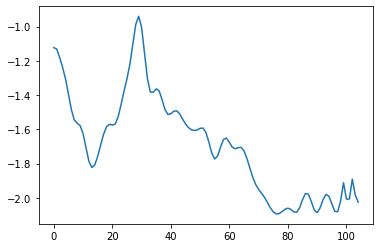

In [0]:
plt.plot(hf_ECG_signals[1][400:505], label = "before hampel filter")
plt.plot(bf_ECG_signals[1][400:505], label = "after hampel filter")
plt.legend()

##4.6 Flat line and peak removal

In [0]:
##

## 4.7 Segmentation

In [0]:
def generate_segment_data(source,seg_len):
  n=0
  signals =[]
  for signal in source:
    for i in range(int(len(signal)/seg_len)):
      seg = signal[seg_len*i:seg_len*(i+1)]
      signals.append(seg)
    n+=1
#convert list into a numpy array and change its dim from (num of records, seg_len, 1) to (num of records, seg_len)
  signals = np.asarray(list(map(lambda x: np.reshape(x,9000),signals)))

  return signals

In [0]:
signals = generate_segment_data(ECG_signals, 9000)
print('signals dim:', signals.shape)
signals = np.expand_dims(signals, axis=1)
print('signals dim after resize', signals.shape)

# 5.Predict Afib using ECG signal

In [0]:
#load model
model = tf.keras.models.load_model('Deep_ECG.h5')

In [0]:
prediction = model.predict(signals)

#6.Label PPG data

##6.1 Resample ECG signals

##6.2 Flip ECG signals

## 6.3 Band pass filter

##6.4 Normalization

##6.5 Hampel filter

## 6.6 Flat line and peak removal

##6.7 Segmentaion

In [0]:
#join table